In [1]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
import numpy as np
import subprocess as sp
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.stats.multitest import fdrcorrection

def save_df_to_npz(obj, filename):
    np.savez_compressed(filename, data=obj.values, index=obj.index.values, columns=obj.columns.values)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

## Make tempdir for intermediate files

In [2]:
outdir = '../../data/tmp'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
miscdir = '../../data/tmp/misc'
if not os.path.exists(miscdir):
    os.mkdir(miscdir)

## Prepare data matrices

In [3]:
phenofn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/preANDpost2016_Merged_Complete_Metadata_WithAge_20210818.tsv'
phenoinfo = pd.read_csv(phenofn, sep='\t')
phenoinfo.index = phenoinfo['Full_IID']
phenoinfo.head()

,Full_IID,Genotype_Sex,ID_Reformat,SampleType,sex,Disease,ISTH_SandR_Key,KGH_Survivor_Key,KGH_AcuteLassa_Key,KGH_AcuteEbola_Key,...,Batch,Country,Sex_Discrepant,Sex_Discrepant_Notes,Status,Clean_HLA_ID,Epoch,Array,CollectionEpoch,Age
Full_IID,,,,,,,,,,,,,,,,,,,,,
July2014NG_SM-6C4M9,July2014NG_SM-6C4M9,1,SM-6C4M9,SuspectedLassaNG,1,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,30.0
July2014NG_SM-4XBS9,July2014NG_SM-4XBS9,2,SM-4XBS9,Pre2016ControlNG,2,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,26.0
July2014NG_SM-6C4MA,July2014NG_SM-6C4MA,1,SM-6C4MA,SuspectedLassaNG,1,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,32.0
July2014NG_SM-6C4MB,July2014NG_SM-6C4MB,2,SM-6C4MB,SuspectedLassaNG,2,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,65.0
July2014NG_SM-4XBSM,July2014NG_SM-4XBSM,2,SM-4XBSM,Pre2016ControlNG,2,Lassa,NaN,NaN,NaN,NaN,...,July2014NG,NG,False,NaN,Passes QC,NaN,Pre2016,Omni_25M_B,Pre2016,47.0


In [4]:
group_fn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016_AggregatedLASVPhenotypes_20210829.tsv'
groups = pd.read_csv(group_fn, sep='\t')
groups.index = groups['#IID']
ind = groups.index[groups['Post2016_NG_LASV_qPCR2xPos'] | groups['Post2016_NG_LASV_SeqPos'] | groups['Pre2016_NG_LASV_SeqPos'] | groups['Pre2016_SL_LASV_AgORSeqPos'] | groups['Post2016_SL_LASV_AgPos']]
phenoinfo['LASV_Case'] = 0
phenoinfo.loc[ind, 'LASV_Case'] = 1

In [5]:
pd.crosstab(phenoinfo['Country'], phenoinfo['Array'])

Array,H3,Omni_25M_A,Omni_25M_B,Omni_5M
Country,,,,
NG,1291,953,129,419
SL,1747,805,418,66


In [6]:
preprereps = pd.read_csv('gs://popgen-gwas/data/metadata/Annotated_GenotypedData/ExpectedDuplicates/Pre2016_DuplicateSelection_Complete_20210724.tsv', sep='\t')
preprereps.head()

,Duplicate_Pair,IID,Duplicate_To_Use,Relatedness,F_MISS,Expected,Notes
0,Fall2013_SM-2986Y---July2014NG_SM-4XBSM,July2014NG_SM-4XBSM,July2014NG_SM-4XBSM,0.998971,0.03793,False,Discrepant age and 1 IgG but doesn't change ph...
1,Fall2013_SM-2986Y---July2014NG_SM-4XBSM,Fall2013_SM-2986Y,July2014NG_SM-4XBSM,0.998971,0.03857,False,Discrepant age and 1 IgG but doesn't change ph...
2,Fall2013_SM-4CY2L---March2012_SM-297Z2,Fall2013_SM-4CY2L,Fall2013_SM-4CY2L,0.992573,0.03201,False,NaN
3,Fall2013_SM-4CY2L---March2012_SM-297Z2,March2012_SM-297Z2,Fall2013_SM-4CY2L,0.992573,0.03310,False,NaN
4,July2014SL_SM-5W5QG---July2014SL_SM-5W5R2,July2014SL_SM-5W5R2,July2014SL_SM-5W5R2,1.035760,0.03945,False,Discrepant age but same phe


In [7]:
prepostreps = pd.read_csv('gs://popgen-gwas/data/metadata/Annotated_GenotypedData/ExpectedDuplicates/Pre_To_Post_Duplicate_Mapping_20190822.tsv', sep='\t')
prepostreps['Pre_ID'].head()

0     Winter2013_F-SL-149F
1      Winter2013_SM-3NQA5
2       Winter2013_F-SL-6C
3      Winter2013_F-SL-71C
4    Winter2013_F-NG-C-84F
Name: Pre_ID, dtype: object

In [8]:
prerepsamples = list(set(preprereps['IID']).union(prepostreps['Pre_ID']))

In [9]:
a = '../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1'

In [10]:
fam = pd.read_csv(a+'.fam', sep=' ', header=None)
fam[4].replace(np.nan, -1).value_counts()

2    1599
1    1181
Name: 4, dtype: int64

In [11]:
fam[1].isin(prerepsamples).value_counts()

False    2331
True      449
Name: 1, dtype: int64

In [12]:
repsamplesfn = a+'.HasReplicateSamples.tsv'
print(repsamplesfn)
fam.loc[fam[1].isin(prerepsamples), [0,1]].to_csv(repsamplesfn, sep='\t', header=None, index=False)

../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1.HasReplicateSamples.tsv


In [13]:
cmd = 'plink --bfile {a} --recode vcf-iid --out {a}.HasReplicateSamples --keep-allele-order --keep {a}.HasReplicateSamples.tsv'.format(a=a)
print(cmd)
!{cmd}

plink --bfile ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1 --recode vcf-iid --out ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1.HasReplicateSamples --keep-allele-order --keep ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1.HasReplicateSamples.tsv
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1.HasReplicateSamples.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1
  --keep ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1.

In [14]:
3

3

In [15]:
repvcffn = '{a}.HasReplicateSamples.vcf'.format(a=a)
repvcf = pd.read_csv(repvcffn, sep='\t', skiprows=29)
print('a')
repvcf.index = repvcf['ID']
repvcf = repvcf.iloc[:,9:]
print('b')
repvcf = repvcf.replace({'1/1':2, '0/0':0, '0/1':1, './.':-1})
print('c')
repvcf.head()

a
b
c


,March2012_SM-298BJ,March2012_SM-2983J,March2012_SM-2983S,March2012_SM-297Z2,March2012_SM-298BM,March2012_SM-297XZ,reGenotypedNov2013_0131_1,Fall2013_SM-2986Y,March2012_SM-2985X,March2012_SM-2F38S,...,Winter2013_SM-3NQ87,Winter2013_SM-3NQ8E,Fall2013_SM-SORX,Fall2013_SM-SORZ,March2012_SM-2F38W,reGenotypedNov2013_SM-8750J_1,March2012_SM-2F38T,reGenotypedNov2013_SM-GRN85_1,reGenotypedNov2013_SM-LW4CG_1,Winter2013_SM-298CL
ID,,,,,,,,,,,,,,,,,,,,,
1:82154:A:G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:564768:T:C,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1:565196:T:C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:565374:A:G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:566206:A:G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
npzvcffn = repvcffn.replace('.vcf', '.vcf.npz')

In [17]:
save_df_to_npz(repvcf, npzvcffn)

In [10]:
npzvcffn = '../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1.HasReplicateSamples.vcf.npz'

In [11]:
repvcf = load_df_from_npz(npzvcffn)

## Now organize into matrices for comparisons of re-genotyped samples

In [12]:
set25A = '../../data/tmp/plink/var25a/HumanOmni2.5-8v1_A_Merged.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.fam'
set25B = '../../data/tmp/plink/var25b/HumanOmni2.5-8v1-1_B_Merged.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.fam'
set5 = '../../data/tmp/plink/var5/HumanOmni5-4v1_B.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.fam'

a25a_samps = list(pd.read_csv(set25A, header=None, sep='\t')[1])
a25b_samps = list(pd.read_csv(set25B, header=None, sep='\t')[1])
a5_samps = list(pd.read_csv(set5, header=None, sep='\t')[1])

### Exclude 66 SL omni 5Msamples from the set

In [13]:
sltoexclude = list(phenoinfo.loc[(phenoinfo['Array'] == 'Omni_5M') & (phenoinfo['Country'] == 'SL'), 'Full_IID'])
a5_samps = set(a5_samps) - set(sltoexclude)

In [14]:
preprereps = pd.read_csv('gs://popgen-gwas/data/metadata/Annotated_GenotypedData/ExpectedDuplicates/Pre2016_DuplicateSelection_Complete_20190822.tsv', sep='\t')
preprereps.head()

,Duplicate_Pair,IID,Duplicate_To_Use,Relatedness,F_MISS,Expected,Notes
0,Fall2013_SM-2986Y---July2014NG_SM-4XBSM,July2014NG_SM-4XBSM,July2014NG_SM-4XBSM,0.998971,0.03793,False,Discrepant age and 1 IgG but doesn't change ph...
1,Fall2013_SM-2986Y---July2014NG_SM-4XBSM,Fall2013_SM-2986Y,July2014NG_SM-4XBSM,0.998971,0.03857,False,Discrepant age and 1 IgG but doesn't change ph...
2,Fall2013_SM-4CY2L---March2012_SM-297Z2,Fall2013_SM-4CY2L,Fall2013_SM-4CY2L,0.992573,0.03201,False,NaN
3,Fall2013_SM-4CY2L---March2012_SM-297Z2,March2012_SM-297Z2,Fall2013_SM-4CY2L,0.992573,0.03310,False,NaN
4,July2014SL_SM-5W5QG---July2014SL_SM-5W5R2,July2014SL_SM-5W5R2,July2014SL_SM-5W5R2,1.035760,0.03945,False,Discrepant age but same phe


In [15]:
pd.crosstab(phenoinfo.loc[[x for x in preprereps['Duplicate_To_Use'].unique() if x != '-1'], 'Array'], phenoinfo.loc[[x for x in preprereps['Duplicate_To_Use'].unique() if x != '-1'], 'Country'])

Country,NG,SL
Array,,
Omni_25M_A,22,4
Omni_25M_B,1,11
Omni_5M,14,65


In [16]:
dupgroups_a25a_a25b = []
dupgroups_a25a_a5 = []
dupgroups_a25b_a5 = []
dupgroups_a25_a5 = []
for dp in preprereps['Duplicate_Pair'].unique():
    items = dp.split('---')
    a25a_list = []
    a25b_list = []
    a5_list = []
    a25ab_list = []

    for i in items:
        if i in a25a_samps:
            a25a_list.append(i)
        elif i in a25b_samps:
            a25b_list.append(i)
        elif i in a5_samps:
            a5_list.append(i)
    
        if (i in a25a_samps) or (i in a25b_samps):
            a25ab_list.append(i)
    
    
    if (len(a25a_list)>0) or (len(a25b_list)>0):
        dupgroups_a25a_a25b.append([a25a_list, a25b_list])

    if (len(a25a_list)>0) or (len(a5_list)>0):
        dupgroups_a25a_a5.append([a25a_list, a5_list])    
            
    if (len(a25b_list)>0) or (len(a5_list)>0):
        dupgroups_a25b_a5.append([a25b_list, a5_list])    

    if (len(a25ab_list)>0) or (len(a5_list)>0):
        dupgroups_a25_a5.append([a25ab_list, a5_list])   

In [17]:
len([x for x in dupgroups_a25a_a25b if (len(x[0])>0) and (len(x[1])>0)]), len([x for x in dupgroups_a25a_a5 if (len(x[0])>0) and (len(x[1])>0)]), len([x for x in dupgroups_a25b_a5 if (len(x[0])>0) and (len(x[1])>0)]), len([x for x in dupgroups_a25_a5 if (len(x[0])>0) and (len(x[1])>0)])

(19, 26, 0, 26)

In [18]:
len([x for x in dupgroups_a25a_a25b if (len(x[0])>0) and (len(x[1])>0)]), len([x for x in dupgroups_a25a_a5 if (len(x[0])>0) and (len(x[1])>0)]), len([x for x in dupgroups_a25b_a5 if (len(x[0])>0) and (len(x[1])>0)]), len([x for x in dupgroups_a25_a5 if (len(x[0])>0) and (len(x[1])>0)])

(19, 26, 0, 26)

In [19]:
def get_concordance(a1dat, a2dat, dupgroups):
    cols = ['B1_AllRep_Concordance', 'B1_Dedup_Concordance', 'B1_AllRep_Total', 'B1_Dedup_Total',
        'B2_AllRep_Concordance', 'B2_Dedup_Concordance', 'B2_AllRep_Total', 'B2_Dedup_Total',
        'Between_AllRep_Concordance', 'Between_Dedup_Concordance', 'Between_AllRep_Total', 'Between_Dedup_Total']
    results = pd.DataFrame(0, index=a1dat.index, columns=cols)
    results.head()

    disc = np.zeros(results.shape[0])
    counter = pd.Series(disc, index=results.index)
    discrepancy = pd.Series(disc, index=results.index)
    for (b1, b2) in dupgroups:
        if len(b1) > 1:
            counter_new = counter.copy()
            discrepancy_new = discrepancy.copy()
            for i in range(len(b1)-1):
                for j in range(i+1, len(b1)):
                    nonnull = (a1dat[b1[i]] != -1) & (a1dat[b1[j]] != -1)
                    counter_new += nonnull
                    discrepancy_new += ((a1dat[b1[i]] != a1dat[b1[j]]) & nonnull)
            results['B1_AllRep_Total'] += counter_new
            results['B1_AllRep_Concordance'] += discrepancy_new
            ind = counter_new > 0
            results.loc[ind, 'B1_Dedup_Concordance'] += (discrepancy_new.loc[ind] / counter_new.loc[ind])
            results.loc[ind, 'B1_Dedup_Total'] += 1
        
        if len(b2) > 1:
            counter_new = counter.copy()
            discrepancy_new = discrepancy.copy()
            for i in range(len(b2)-1):
                for j in range(i+1, len(b2)):
                    nonnull = (a2dat[b2[i]] != -1) & (a2dat[b2[j]] != -1)
                    counter_new += nonnull
                    discrepancy_new += ((a2dat[b2[i]] != a2dat[b2[j]]) & nonnull)
            results['B2_AllRep_Total'] += counter_new
            results['B2_AllRep_Concordance'] += discrepancy_new
            ind = counter_new > 0
            results.loc[ind, 'B2_Dedup_Concordance'] += (discrepancy_new.loc[ind] / counter_new.loc[ind])
            results.loc[ind, 'B2_Dedup_Total'] += 1        
        
        if (len(b1) > 0) and (len(b2) > 0) :
            counter_new = counter.copy()
            discrepancy_new = discrepancy.copy()
            for i in range(len(b1)):
                for j in range(len(b2)):
                    nonnull = (a1dat[b1[i]] != -1) & (a2dat[b2[j]] != -1)
                    counter_new += nonnull
                    discrepancy_new += ((a1dat[b1[i]] != a2dat[b2[j]]) & nonnull)
            results['Between_AllRep_Total'] += counter_new
            results['Between_AllRep_Concordance'] += discrepancy_new
            ind = counter_new > 0
            results.loc[ind, 'Between_Dedup_Concordance'] += (discrepancy_new.loc[ind] / counter_new.loc[ind])
            results.loc[ind, 'Between_Dedup_Total'] += 1
            
    return(results)

In [20]:
a25a_samps_overlap = list(set(a25a_samps).intersection(repvcf.columns))
a25b_samps_overlap = list(set(a25b_samps).intersection(repvcf.columns))
a25_samps_overlap = a25a_samps_overlap + a25b_samps_overlap
a5_samps_overlap = list(set(a5_samps).intersection(repvcf.columns))

In [21]:
repvcf[a25a_samps_overlap].head()

,Winter2013_SM-299PT,Winter2013_SM-39NA9,Winter2013_SM-3NQK4,reGenotypedNov2013_C-0104_1,Winter2013_SM-3MFLL,Winter2013_SM-3NQKK,Winter2013_SM-39SMF,Winter2013_SM-39SMN,Winter2013_F-NG-C-106F,Winter2013_F-SL-12C,...,Fall2013_SM-3KQFV,Winter2013_SM-39SMX,Winter2013_SM-3NQK5,Winter2013_SM-39NBF,Fall2013_SM-2989W,Winter2013_F-NG-C-49F,Winter2013_F-SL-48C,Fall2013_SM-4CDLT,Winter2013_F-NG-NC-140F,Fall2013_SM-29898
1:82154:A:G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:564768:T:C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:565196:T:C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:565374:A:G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:566206:A:G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
conc_a25a_a25b = get_concordance(repvcf[a25a_samps_overlap], repvcf[a25b_samps_overlap], dupgroups_a25a_a25b)
save_df_to_npz(conc_a25a_a25b, '../../data/tmp/plink/merged_pre2016/replicate_concordance_a25a_vs_a25b_20210715.npz')

Text(0.5, 1.0, '25a vs 25b - All replicates')

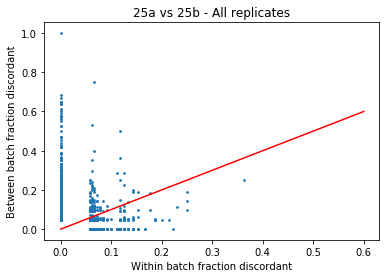

In [23]:
totest = conc_a25a_a25b
x = (totest['B1_AllRep_Concordance'] + totest['B2_AllRep_Concordance']) / (totest['B1_AllRep_Total'] + totest['B2_AllRep_Total'])
#x = results['B1_AllRep_Concordance'] / results['B1_AllRep_Total']
y = totest['Between_AllRep_Concordance'] / totest['Between_AllRep_Total']
ind = (x>0) | (y>0)
plt.scatter(x.loc[ind], y.loc[ind], s=3)
plt.plot([0,.6], [0,.6], color='r')

plt.xlabel('Within batch fraction discordant')
plt.ylabel('Between batch fraction discordant')
plt.title('25a vs 25b - All replicates')

In [24]:
conc_a25a_a25b['Between_AllRep_Total'].value_counts().head()

22.0    2116910
21.0     133342
20.0      37705
19.0      12517
18.0       4769
Name: Between_AllRep_Total, dtype: int64

In [25]:
((conc_a25a_a25b['B1_AllRep_Total'] + conc_a25a_a25b['B2_AllRep_Total'])).value_counts().head()

17.0    2060235
16.0     183659
15.0      41928
14.0      14241
13.0       5352
dtype: int64

In [26]:
conc_a25a_a5 = get_concordance(repvcf[a25a_samps_overlap], repvcf[a5_samps_overlap], dupgroups_a25a_a5)
save_df_to_npz(conc_a25a_a5, '../../data/tmp/plink/merged_pre2016/replicate_concordance_a25a_vs_a5_20210715.npz')

Text(0.5, 1.0, '25a vs 5 - All replicates')

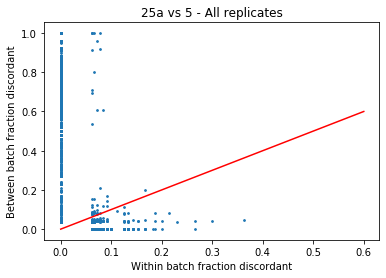

In [27]:
totest = conc_a25a_a5
x = (totest['B1_AllRep_Concordance'] + totest['B2_AllRep_Concordance']) / (totest['B1_AllRep_Total'] + totest['B2_AllRep_Total'])
#x = results['B1_AllRep_Concordance'] / results['B1_AllRep_Total']
y = totest['Between_AllRep_Concordance'] / totest['Between_AllRep_Total']
ind = (x>0) | (y>0)
plt.scatter(x.loc[ind], y.loc[ind], s=3)
plt.plot([0,.6], [0,.6], color='r')

plt.xlabel('Within batch fraction discordant')
plt.ylabel('Between batch fraction discordant')
plt.title('25a vs 5 - All replicates')

In [28]:
conc_a25b_a5 = get_concordance(repvcf[a25b_samps_overlap], repvcf[a5_samps_overlap], dupgroups_a25b_a5)
save_df_to_npz(conc_a25b_a5, '../../data/tmp/plink/merged_pre2016/replicate_concordance_a25b_vs_a5_20210715.npz')

In [29]:
conc_a25b_a5['B1_AllRep_Total'].max(), conc_a25b_a5['B2_AllRep_Total'].max()

(3.0, 2.0)

Text(0.5, 1.0, '25b vs 5 - All replicates')

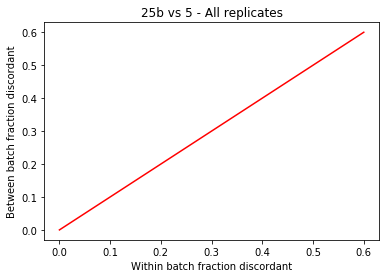

In [30]:
totest = conc_a25b_a5
x = (totest['B1_AllRep_Concordance'] + totest['B2_AllRep_Concordance']) / (totest['B1_AllRep_Total'] + totest['B2_AllRep_Total'])
#x = results['B1_AllRep_Concordance'] / results['B1_AllRep_Total']
y = totest['Between_AllRep_Concordance'] / totest['Between_AllRep_Total']
ind = (x>0) | (y>0)
plt.scatter(x.loc[ind], y.loc[ind], s=3)
plt.plot([0,.6], [0,.6], color='r')

plt.xlabel('Within batch fraction discordant')
plt.ylabel('Between batch fraction discordant')
plt.title('25b vs 5 - All replicates')

In [31]:
conc_a25_a5 = get_concordance(repvcf[a25_samps_overlap], repvcf[a5_samps_overlap], dupgroups_a25_a5)
save_df_to_npz(conc_a25_a5, '../../data/tmp/plink/merged_pre2016/replicate_concordance_a25_vs_a5_20210715.npz')

Text(0.5, 1.0, '25combined vs 5 - All replicates')

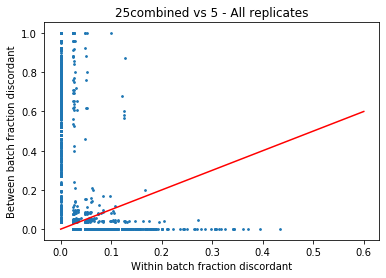

In [32]:
totest = conc_a25_a5
x = (totest['B1_AllRep_Concordance'] + totest['B2_AllRep_Concordance']) / (totest['B1_AllRep_Total'] + totest['B2_AllRep_Total'])
#x = results['B1_AllRep_Concordance'] / results['B1_AllRep_Total']
y = totest['Between_AllRep_Concordance'] / totest['Between_AllRep_Total']
ind = (x>0) | (y>0)
plt.scatter(x.loc[ind], y.loc[ind], s=3)
plt.plot([0,.6], [0,.6], color='r')

plt.xlabel('Within batch fraction discordant')
plt.ylabel('Between batch fraction discordant')
plt.title('25combined vs 5 - All replicates')

## Compare to GWAS association approach

In [33]:
dupres = {}
dupres['25a_vs_25b'] = load_df_from_npz('../../data/tmp/plink/merged_pre2016/replicate_concordance_a25a_vs_a25b_20210715.npz')
dupres['25a_vs_5'] = load_df_from_npz('../../data/tmp/plink/merged_pre2016/replicate_concordance_a25a_vs_a5_20210715.npz')
dupres['25b_vs_5'] = load_df_from_npz('../../data/tmp/plink/merged_pre2016/replicate_concordance_a25b_vs_a5_20210715.npz')
dupres['25_vs_5'] = load_df_from_npz('../../data/tmp/plink/merged_pre2016/replicate_concordance_a25_vs_a5_20210715.npz')

In [34]:
a25a_fn = '../../data/tmp/plink/var25a/HumanOmni2.5-8v1_A_Merged.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.fam'
a25a_fam = pd.read_csv(a25a_fn, sep='\t', header=None)

a25b_fn = '../../data/tmp/plink/var25b/HumanOmni2.5-8v1-1_B_Merged.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.fam'
a25b_fam = pd.read_csv(a25b_fn, sep='\t', header=None)

a5_fn = '../../data/tmp/plink/var5/HumanOmni5-4v1_B.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.fam'
a5_fam = pd.read_csv(a5_fn, sep='\t', header=None)

In [35]:
sltoexclude = list(phenoinfo.loc[(phenoinfo['Array'] == 'Omni_5M') & (phenoinfo['Country'] == 'SL'), 'Full_IID'])
a5_samps_tokeep = set(a5_fam[1]) - set(sltoexclude)
a5_fam[1].isin(a5_samps).value_counts()

True     419
False     66
Name: 1, dtype: int64

In [36]:
a5_fam = a5_fam.loc[a5_fam[1].isin(a5_samps_tokeep), :]

In [37]:
a5_fam.shape

(419, 6)

In [38]:
a25_fam = pd.concat([a25a_fam, a25b_fam], axis=0)

In [39]:
fullbase = '../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1'

 

In [40]:
comparisons = [
[a25a_fam, a25b_fam, '25a_vs_25b'],
[a25a_fam, a5_fam, '25a_vs_5'],
[a25b_fam, a5_fam, '25b_vs_5'],
[a25_fam, a5_fam, '25_vs_5'],
]

In [41]:
for c in comparisons:
    z = pd.concat([c[0], c[1]], axis=0)
    z.loc[z[1].isin(c[1][1]), 5] = 1
    z.loc[z[1].isin(c[0][1]), 5] = 0
    z['Country'] = phenoinfo.loc[z[1], 'Country'].values
    print(c[2])
    display(pd.crosstab(z[5].replace(np.nan, -1), z['Country'].replace(np.nan, 'null')))

25a_vs_25b


Country,NG,SL
5,,
0,950,805
1,124,416


25a_vs_5


Country,NG,SL
5,,
0,950,805
1,419,0


25b_vs_5


Country,NG,SL
5,,
0,124,416
1,419,0


25_vs_5


Country,NG,SL
5,,
0,1074,1221
1,419,0


In [42]:
workingdir = '../../data/tmp/plink/merged_pre2016/'
for c in comparisons:
    keep_list_fn = workingdir + c[2] + '_SamplesToKeep.tsv'
    outbase = workingdir + c[2] + '.NoDups.20210804'
    merged_keep_list = pd.concat([c[0], c[1]], axis=0)
    dupstofilt = list(preprereps.loc[preprereps['IID']!=preprereps['Duplicate_To_Use'], 'IID'])
    merged_keep_list = merged_keep_list.loc[~merged_keep_list[1].isin(dupstofilt), :]
    merged_keep_list.iloc[:,:2].to_csv(keep_list_fn, sep='\t', index=False, header=False)
    cmd = 'plink --make-bed --bfile {a} --keep {keepfn} --keep-allele-order --out {out}'.format(a=fullbase, keepfn=keep_list_fn, out=outbase)
    print(cmd)
    !{cmd}

    fam = pd.read_csv(outbase+'.fam', sep=' ', header=None)
    fam.loc[fam[1].isin(c[1][1]),5] = 1
    fam.loc[fam[1].isin(c[0][1]),5] = 0
    print(fam[5].value_counts())
    fam.to_csv(outbase+'.fam', sep=' ', header=False, index=False)    
    
    print(c[2])
    fam_fordisplay = fam.copy()
    fam_fordisplay['Country'] = phenoinfo.loc[fam_fordisplay[1], 'Country'].values
    display(pd.crosstab(fam_fordisplay[5].replace(np.nan, -1), fam_fordisplay['Country'].replace(np.nan, 'null')))
    
    #produce a pruned subset of markers that are in approximate linkage equilibrium with each other
    prunefn = outbase + '.prune.ld_3e-1.maf_1e-1'
    prune_cmd = 'plink --bfile {adat} --out {adatout} --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1'.format(adat=outbase, adatout=prunefn)
    print(prune_cmd)
    !{prune_cmd}

    #do PCA
    pca_cmd = 'plink --bfile {adat} --out {adatout} --pca 20 --extract {adatout}.prune.in'.format(adat=outbase, adatout=prunefn)
    print(pca_cmd)
    !{pca_cmd}

    #make square relationship matrix 
    relfn = outbase + '.prune.ld_3e-1.maf_1e-1'
    rel_cmd = 'plink --make-rel square --bfile {adat} --out {adatout} --extract {prune}.prune.in'.format(adat=outbase, adatout=relfn, prune=prunefn)
    print(rel_cmd)
    !{rel_cmd}

    
    #excludes one member of each pair of samples with observed genomic relatedness greater than the given cutoff value
    #unrelatedsfn = outbase + 'unrelated.individuals.5e-2.txt'
    #get_unrelateds_cmd = 'plink --rel-cutoff 0.05 --grm-bin {rel} --out {out}'.format(rel=relfn, out=unrelatedsfn)
    #print(get_unrelateds_cmd)
    #!{get_unrelateds_cmd}
    
    relid = pd.read_csv(relfn+'.rel.id', header=None, sep ='\t')[1].iloc[0:]
    rel = pd.read_csv(relfn+'.rel', header=None, sep='\t')
    rel.index = relid
    rel.columns = relid
    rel.to_csv(relfn+'.rel.withids.tsv', sep='\t')
    
    phenofn = outbase + '.cov'
    cov = pd.read_csv(outbase+'.fam', sep=' ', header=None)
    cov = cov[[0,1,5]]
    cov.columns = ['FID', 'IID', 'Batch']
    cov.index = cov['IID']
        
    cov['Country'] = phenoinfo.loc[cov['IID'], 'Country'].replace({'NG':'0', 'SL':'1'}).replace(np.nan, '-9').values
    #cov['Batch'] = phenoinfo.loc[cov['IID'], 'Array'].replace({'Omni_25M_B':0, 'Omni_25M_A':0, 'Omni_5M':0, 'H3':1}).values
    cov['LASV_Case'] = phenoinfo.loc[cov['IID'], 'LASV_Case'].replace(np.nan, 0).values    
    
    print(cov['Batch'].value_counts())
    print(cov['Country'].value_counts())    
    cov.to_csv(phenofn, sep='\t', index=False)

plink --make-bed --bfile ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1 --keep ../../data/tmp/plink/merged_pre2016/25a_vs_25b_SamplesToKeep.tsv --keep-allele-order --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NoDups.20210804
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NoDups.20210804.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1
  --keep ../../data/tmp/plink/merged_pre2016/25a_vs_25b_SamplesToKeep.tsv
  --keep-allele-order
  --make-bed
  --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NoDups.20210804

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 12062 MB successfully, after larger attempt(s) failed.
2308998 variants loa

Country,NG,SL
5,,
0,931,780
1,124,346


plink --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NoDups.20210804 --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NoDups.20210804.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NoDups.20210804.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NoDups.20210804
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NoDups.20210804.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 12062 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
2181 people (955 males, 1226 females) loaded from .fam.
470 phenotype values loaded from 

Country,NG,SL
5,,
0,931,780
1,402,0


plink --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_5.NoDups.20210804 --out ../../data/tmp/plink/merged_pre2016/25a_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25a_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_5.NoDups.20210804
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25a_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 12062 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
2113 people (907 males, 1206 females) loaded from .fam.
402 phenotype values loaded from .fam.
Usin

Country,NG,SL
5,,
0,124,346
1,402,0


plink --bfile ../../data/tmp/plink/merged_pre2016/25b_vs_5.NoDups.20210804 --out ../../data/tmp/plink/merged_pre2016/25b_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25b_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25b_vs_5.NoDups.20210804
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25b_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 12062 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
872 people (350 males, 522 females) loaded from .fam.
402 phenotype values loaded from .fam.
Using 

Country,NG,SL
5,,
0,1055,1126
1,402,0


plink --bfile ../../data/tmp/plink/merged_pre2016/25_vs_5.NoDups.20210804 --out ../../data/tmp/plink/merged_pre2016/25_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25_vs_5.NoDups.20210804
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 12062 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
2583 people (1106 males, 1477 females) loaded from .fam.
402 phenotype values loaded from .fam.
Using 1 

In [43]:
! gsutil -m rsync -r ../../data/tmp/plink/merged_pre2016 gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016

Building synchronization state...
Starting synchronization...
Computing MD5 for file://../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.bed...
Computing MD5 for file://../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.bim...
Copying mtime from src to dst for gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NG.NoDups.20210805.bed
Copying mtime from src to dst for gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NG.NoDups.20210805.bim
Computing MD5 for file://../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.hh...
Copying mtime from src to dst for gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NG.NoDups.20210805.cov
Computing MD5 for file://../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.nullmodelCovCC.rds...
Copying mtime from src to dst for gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NG.NoDups.20210

In [44]:
comparison_strs = ['25a_vs_25b', '25a_vs_5', '25b_vs_5', '25_vs_5']

In [106]:
scriptfn = 'gs://ebola-gwas-lbr/Code/run_GMMAT_fromPLINK_parallel.R'
container = 'quay.io/dkotliar/gmmat_mkl:0.4'
ncores = 7
    
subcmdbase = '''dsub --project sabeti-ebola-gwas \
--name %s --provider google-v2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" \
--logging %s \
--image %s --ssh \
--input SCRIPT=%s \
--input BEDFILE=%s.bed \
--input FAMFILE=%s.fam \
--input BIMFILE=%s.bim \
--input COVFILE=%s.cov \
--input RELATFILE=%s \
--output NULLFILE=%s \
--output OUTFINAL=%s \
--env FORMULA='Batch ~ Country + LASV_Case + 1\' \
--env NCORES=7 \
--script submit.sh'''   

workingdir = 'gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/'
dsub_cmds = []

for c in comparison_strs:
    name = '%s_CovCC_minfilt' % c
    logbase = os.path.join(workingdir, 'log', "{job-name}-{job-id}.log")    

    bedbase = workingdir + c + '.NoDups.20210804'
    relfile = bedbase + '.prune.ld_3e-1.maf_1e-1.rel.withids.tsv'

    nulloutfile = bedbase + ".nullmodelCovCC.rds"
    outfinal = bedbase + ".resultsCovCC.tsv"

    fullcmd = subcmdbase % (name,logbase,container,scriptfn, bedbase, bedbase, bedbase, bedbase, relfile, nulloutfile, outfinal) 
    dsub_cmds.append(fullcmd)

In [70]:
! {dsub_cmds[0]}

Job properties:
  job-id: 25a-vs-25b--dkotliar--220109-004120-97
  job-name: 25a-vs-25b-covcc-minfilt
  user-id: dkotliar
Provider internal-id (operation): projects/sabeti-ebola-gwas/operations/6253864269701721372
Launched job-id: 25a-vs-25b--dkotliar--220109-004120-97
To check the status, run:
  dstat --provider google-v2 --project sabeti-ebola-gwas --jobs '25a-vs-25b--dkotliar--220109-004120-97' --users 'dkotliar' --status '*'
To cancel the job, run:
  ddel --provider google-v2 --project sabeti-ebola-gwas --jobs '25a-vs-25b--dkotliar--220109-004120-97' --users 'dkotliar'
25a-vs-25b--dkotliar--220109-004120-97


In [107]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs '25a-vs-25b--dkotliar--220109-004120-97' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
25a-vs-25b-c...  Success   01-09 01:42:13



In [108]:
! {dsub_cmds[1]}

Job properties:
  job-id: 25a-vs-5-c--dkotliar--220109-191934-88
  job-name: 25a-vs-5-covcc-minfilt
  user-id: dkotliar
Provider internal-id (operation): projects/sabeti-ebola-gwas/operations/1690340037008585611
Launched job-id: 25a-vs-5-c--dkotliar--220109-191934-88
To check the status, run:
  dstat --provider google-v2 --project sabeti-ebola-gwas --jobs '25a-vs-5-c--dkotliar--220109-191934-88' --users 'dkotliar' --status '*'
To cancel the job, run:
  ddel --provider google-v2 --project sabeti-ebola-gwas --jobs '25a-vs-5-c--dkotliar--220109-191934-88' --users 'dkotliar'
25a-vs-5-c--dkotliar--220109-191934-88


In [118]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs '25a-vs-5-c--dkotliar--220109-191934-88' --users 'dkotliar' --status '*'


Job Name         Status    Last Update
---------------  --------  --------------
25a-vs-5-cov...  Success   01-09 20:29:09



In [109]:
! {dsub_cmds[2]}

Job properties:
  job-id: 25b-vs-5-c--dkotliar--220109-191950-95
  job-name: 25b-vs-5-covcc-minfilt
  user-id: dkotliar
Provider internal-id (operation): projects/sabeti-ebola-gwas/operations/7205520904997400553
Launched job-id: 25b-vs-5-c--dkotliar--220109-191950-95
To check the status, run:
  dstat --provider google-v2 --project sabeti-ebola-gwas --jobs '25b-vs-5-c--dkotliar--220109-191950-95' --users 'dkotliar' --status '*'
To cancel the job, run:
  ddel --provider google-v2 --project sabeti-ebola-gwas --jobs '25b-vs-5-c--dkotliar--220109-191950-95' --users 'dkotliar'
25b-vs-5-c--dkotliar--220109-191950-95


In [117]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs '25b-vs-5-c--dkotliar--220109-191950-95' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
25b-vs-5-cov...  Success   01-09 20:03:28



In [54]:
repcmd = dsub_cmds[-1].replace('--min-ram 8', '--min-ram 16')
print(repcmd)
!{repcmd}

dsub --project sabeti-ebola-gwas --name 25_vs_5_CovCC_minfilt --provider google-v2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" --logging gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/log/{job-name}-{job-id}.log --image quay.io/dkotliar/gmmat_mkl:0.4 --ssh --input SCRIPT=gs://ebola-gwas-lbr/Code/run_GMMAT_fromPLINK_parallel.R --input BEDFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NoDups.20210804.bed --input FAMFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NoDups.20210804.fam --input BIMFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NoDups.20210804.bim --input COVFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NoDups.20210804.cov --input RELATFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NoDups.20210804.prune.ld_3e-1.maf_1e-

In [110]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs '25-vs-5-co--dkotliar--220109-002515-30' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
25-vs-5-covc...  Success   01-09 01:52:50



In [119]:
! gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/*.NoDups.20210804.resultsCovCC.tsv ../../data/tmp/plink/merged_pre2016/
! gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/*.NoDups.20210804.nullmodelCovCC.rds ../../data/tmp/plink/merged_pre2016/

Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NoDups.20210804.resultsCovCC.tsv...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.NoDups.20210804.resultsCovCC.tsv...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_5.NoDups.20210804.resultsCovCC.tsv...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25b_vs_5.NoDups.20210804.resultsCovCC.tsv...
/ [4/4 files][925.5 MiB/925.5 MiB] 100% Done                                    
Operation completed over 4 objects/925.5 MiB.                                    
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NoDups.20210804.nullmodelCovCC.rds...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.NoDups.20210804.nullmodelCovCC.rds...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pr

In [120]:
## workingdir = '../../data/tmp/plink/merged_pre2016/'
for c in comparisons:
    v = c[2]
    dupres[v]['Between_AllRep_FracConcordant'] = dupres[v]['Between_AllRep_Concordance'] / dupres[v]['Between_AllRep_Total']
    dupres[v]['Within_AllRep_FracConcordant']  = (dupres[v]['B1_AllRep_Concordance'] + dupres[v]['B2_AllRep_Concordance']) / (dupres[v]['B1_AllRep_Total'] + dupres[v]['B2_AllRep_Total'])

In [121]:
for c in comparisons:
    v = c[2]
    gwasfn = workingdir + v + '.NoDups.20210804.resultsCovCC.tsv'
    gwasres = pd.read_csv(gwasfn, sep='\t', nrows=5)
    print(v)
    display(gwasres)

25a_vs_25b


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
0,1:564768:T:C,1,564768,T,C,2174,0.003210,0.063477,-6.972617,67.349466,0.395532
1,1:565374:A:G,1,565374,A,G,2180,0.000459,0.000459,1.627407,0.546531,0.027711
2,1:568072:A:G,1,568072,A,G,2161,0.009170,0.393568,-7.964141,268.757666,0.627108
3,1:569342:T:C,1,569342,T,C,2114,0.030720,0.001892,-1.986208,2.559729,0.214441
4,1:723918:G:A,1,723918,G,A,2163,0.008253,0.084836,12.782399,41.124431,0.046234


25a_vs_5


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
0,1:564768:T:C,1,564768,T,C,2110,0.001420,0.067773,0.153085,13.084122,0.966243
1,1:568072:A:G,1,568072,A,G,2095,0.008519,0.416945,0.025952,48.741511,0.997034
2,1:569342:T:C,1,569342,T,C,2048,0.030762,0.001953,0.002560,0.000021,0.575003
3,1:723918:G:A,1,723918,G,A,2100,0.006152,0.085238,0.490065,7.744960,0.860220
4,1:752566:G:A,1,752566,G,A,2113,0.000000,0.311169,-0.102255,20.665791,0.982054


25b_vs_5


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
0,1:564768:T:C,1,564768,T,C,868,0.004587,0.061060,0.452520,9.689136,0.884413
1,1:565374:A:G,1,565374,A,G,872,0.000000,0.001147,-0.496260,0.482328,0.474882
2,1:568072:A:G,1,568072,A,G,868,0.004587,0.404378,-0.645667,37.597778,0.916138
3,1:723918:G:A,1,723918,G,A,863,0.010321,0.100232,0.153670,6.102123,0.950397
4,1:752566:G:A,1,752566,G,A,870,0.002294,0.318391,-0.293164,16.616394,0.942666


25_vs_5


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
0,1:564768:T:C,1,564768,T,C,2576,0.002710,0.064829,0.160296,11.817094,0.962808
1,1:565374:A:G,1,565374,A,G,2582,0.000387,0.000387,-0.054618,0.096287,0.860281
2,1:568072:A:G,1,568072,A,G,2562,0.008130,0.404957,0.001822,44.070881,0.999781
3,1:569342:T:C,1,569342,T,C,2500,0.032133,0.001600,0.001699,0.000013,0.637657
4,1:723918:G:A,1,723918,G,A,2563,0.007743,0.087593,0.372836,7.025244,0.888134


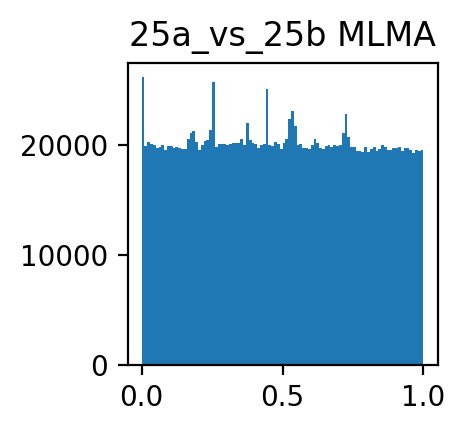

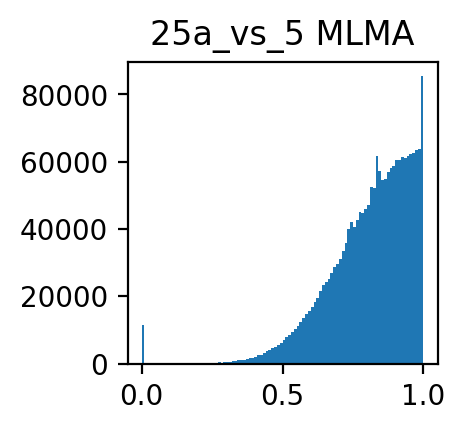

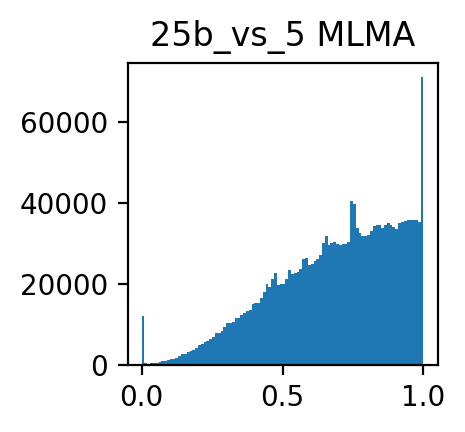

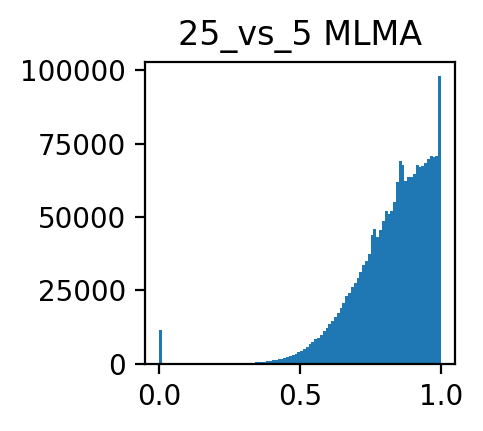

In [122]:
workingdir = '../../data/tmp/plink/merged_pre2016/'
for c in comparisons:
    v = c[2]
    gwasfn = workingdir + v + '.NoDups.20210804.resultsCovCC.tsv'
    #gwasres = pd.read_csv(gwasfn, sep='\t', header=None)
    gwasres = pd.read_csv(gwasfn, sep='\t')
    #gwasres.columns = ['SNP','CHR','POS','REF','ALT','N','MISSRATE','AF','SCORE','VAR','PVAL']
    gwasres.index = gwasres['SNP']
    (fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
    ax.hist(gwasres['PVAL'], bins=100)
    ax.set_title(v + ' MLMA')
    dupres[v]['MLMA_P'] = np.nan
    dupres[v]['MLMA_Q'] = np.nan
    overlap = list(set(dupres[v].index).intersection(set(gwasres.index)))
    dupres[v].loc[overlap, 'MLMA_P'] = gwasres.loc[overlap, 'PVAL'].values
    dupres[v].loc[overlap, 'MLMA_Q'] =fdrcorrection(dupres[v].loc[overlap, 'MLMA_P'], method='indep')[1]
    dupres[v].loc[overlap, 'MLMA_logP'] = -1*dupres[v].loc[overlap, 'MLMA_P'].apply(np.log10)
    dupres[v].loc[overlap, 'MLMA_logQ'] = -1*dupres[v].loc[overlap, 'MLMA_Q'].apply(np.log10)

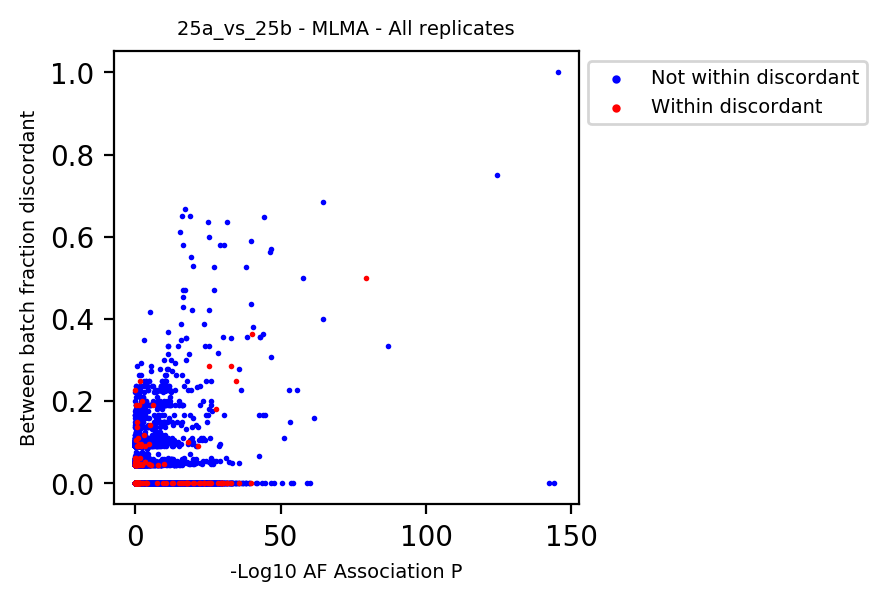

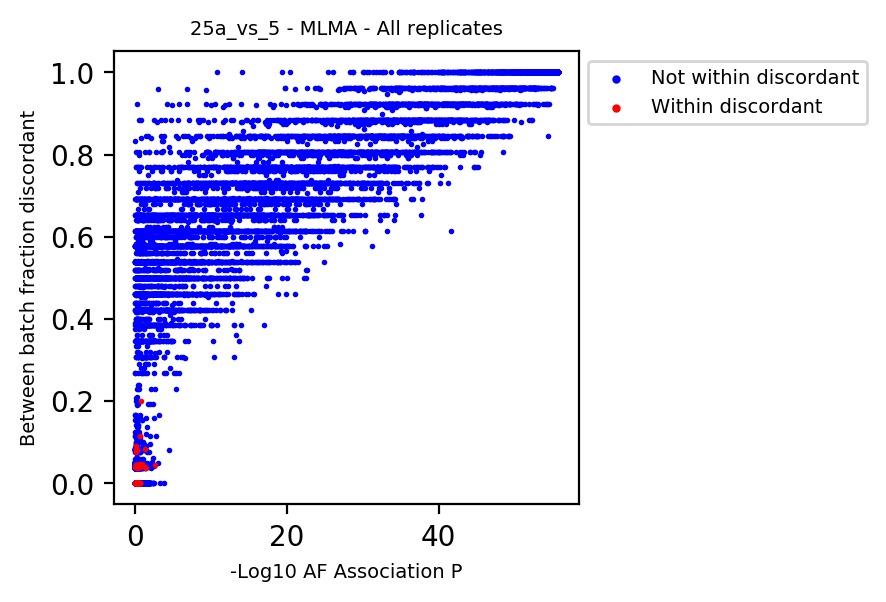

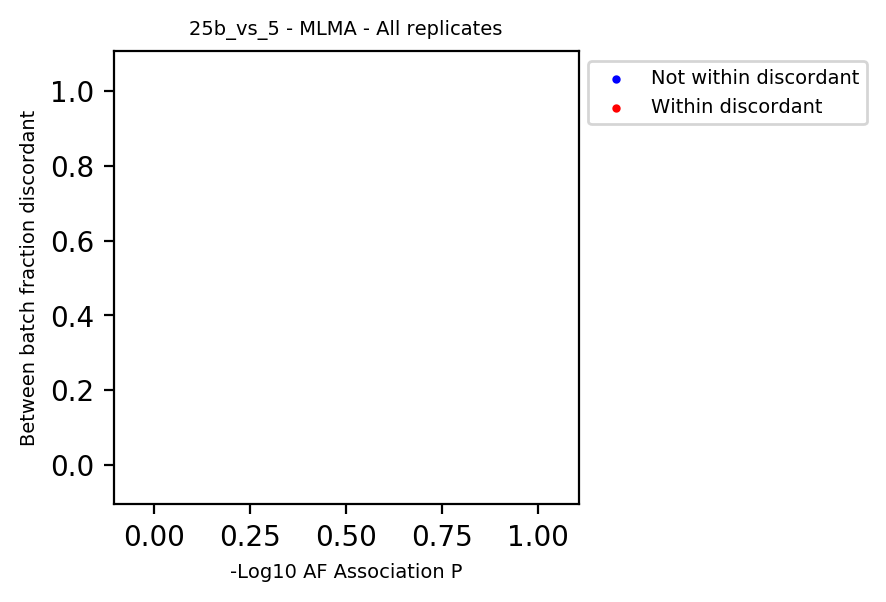

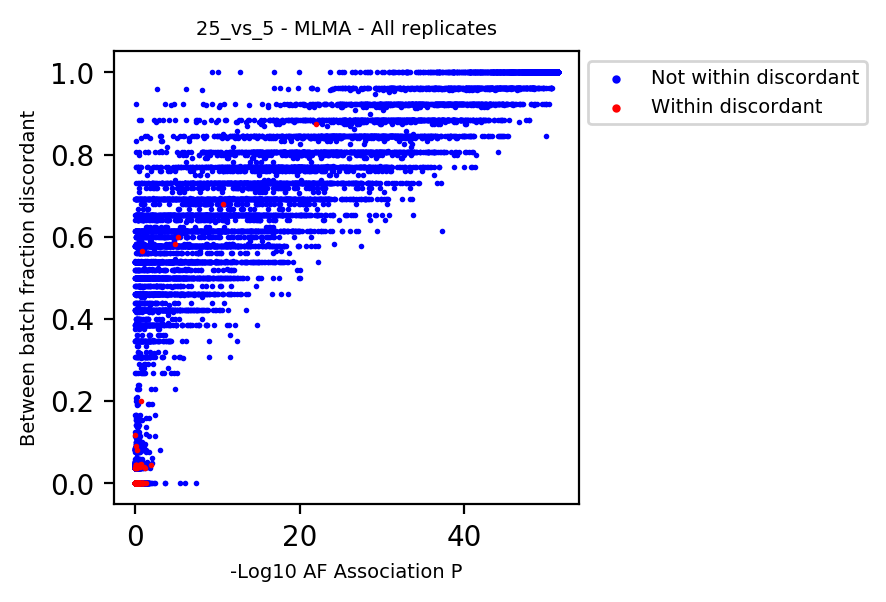

In [123]:
s=1
for c in comparisons:
    v = c[2]
    x = dupres[v].loc[:, 'MLMA_logP']
    y = dupres[v].loc[:, 'Between_AllRep_FracConcordant']
    ind = ~x.isnull()
    iswithindisc = (dupres[v].loc[:, 'Within_AllRep_FracConcordant']>0.1)
    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
    ax.scatter(x.loc[ind & ~iswithindisc], y.loc[ind & ~iswithindisc], s=s, color='b', label='Not within discordant')
    ax.scatter(x.loc[ind & iswithindisc], y.loc[ind & iswithindisc], s=s, color='r', label='Within discordant')
    ax.legend(loc='upper left', markerscale=2, fontsize=7, bbox_to_anchor=(1,1))
    ax.set_xlabel('-Log10 AF Association P', fontsize=7)
    ax.set_ylabel('Between batch fraction discordant', fontsize=7)
    ax.set_title(v+ ' - MLMA - All replicates', fontsize=7)

In [124]:
logp_thresh = -1*np.log10(5*(10**-8))
discthresh = .1
for c in comparisons:
    v = c[2]
    x = dupres[v].loc[:, 'MLMA_logP']
    y = dupres[v].loc[:, 'Between_AllRep_FracConcordant']
    print(v)
    display(pd.crosstab(x>logp_thresh, y>discthresh))

25a_vs_25b


Between_AllRep_FracConcordant,False,True
MLMA_logP,,
False,2306201,444
True,1971,382


25a_vs_5


Between_AllRep_FracConcordant,False,True
MLMA_logP,,
False,2295758,3419
True,0,9821


25b_vs_5


Between_AllRep_FracConcordant,False
MLMA_logP,
False,2298938
True,10060


25_vs_5


Between_AllRep_FracConcordant,False,True
MLMA_logP,,
False,2295757,3679
True,1,9561


## Repeat analysis for 25A vs 25B but for NG and SL separately

In [125]:
workingdir = '../../data/tmp/plink/merged_pre2016/'
dsub_cmds = []

for country in ['NG', 'SL']:
    country_samps = phenoinfo.loc[phenoinfo['Country']==country, 'Full_IID']
    for c in comparisons:
        if (country == 'SL') and (c[2] != '25a_vs_25b'):
            continue
         
        keep_list_fn = workingdir + c[2] + '.' + country + '.SamplesToKeep.tsv'
        #print(keep_list_fn)
        outbase = workingdir + c[2] + '.' + country + '.NoDups.20210805'
        merged_keep_list = pd.concat([c[0], c[1]], axis=0)
        merged_keep_list = merged_keep_list.loc[merged_keep_list[1].isin(country_samps), :]        
        dupstofilt = list(preprereps.loc[preprereps['IID']!=preprereps['Duplicate_To_Use'], 'IID'])
        merged_keep_list = merged_keep_list.loc[~merged_keep_list[1].isin(dupstofilt), :]
        merged_keep_list.iloc[:,:2].to_csv(keep_list_fn, sep='\t', index=False, header=False)
        cmd = 'plink --make-bed --bfile {a} --keep {keepfn} --keep-allele-order --out {out}'.format(a=fullbase, keepfn=keep_list_fn, out=outbase)
        print(cmd)
        !{cmd}
        
        fam = pd.read_csv(outbase+'.fam', sep=' ', header=None)
        fam.loc[fam[1].isin(c[1][1]),5] = 1
        fam.loc[fam[1].isin(c[0][1]),5] = 0
        print(fam[5].value_counts())
        fam.to_csv(outbase+'.fam', sep=' ', header=False, index=False)    

        print(c[2])
        fam_fordisplay = fam.copy()
        fam_fordisplay['Country'] = phenoinfo.loc[fam_fordisplay[1], 'Country'].values
        display(pd.crosstab(fam_fordisplay[5].replace(np.nan, -1), fam_fordisplay['Country'].replace(np.nan, 'null')))
        
        #produce a pruned subset of markers that are in approximate linkage equilibrium with each other
        prunefn = outbase + '.prune.ld_3e-1.maf_1e-1'
        prune_cmd = 'plink --bfile {adat} --out {adatout} --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1'.format(adat=outbase, adatout=prunefn)
        print(prune_cmd)
        !{prune_cmd}

        #do PCA
        pca_cmd = 'plink --bfile {adat} --out {adatout} --pca 20 --extract {adatout}.prune.in'.format(adat=outbase, adatout=prunefn)
        print(pca_cmd)
        !{pca_cmd}

        #make square relationship matrix 
        relfn = outbase + '.prune.ld_3e-1.maf_1e-1'
        rel_cmd = 'plink --make-rel square --bfile {adat} --out {adatout} --extract {prune}.prune.in'.format(adat=outbase, adatout=relfn, prune=prunefn)
        print(rel_cmd)
        !{rel_cmd}
        
        #excludes one member of each pair of samples with observed genomic relatedness greater than the given cutoff value
        #unrelatedsfn = outbase + 'unrelated.individuals.5e-2.txt'
        #get_unrelateds_cmd = 'plink --rel-cutoff 0.05 --grm-bin {rel} --out {out}'.format(rel=relfn, out=unrelatedsfn)
        #print(get_unrelateds_cmd)
        #!{get_unrelateds_cmd}

        relid = pd.read_csv(relfn+'.rel.id', header=None, sep ='\t')[1].iloc[0:]
        rel = pd.read_csv(relfn+'.rel', header=None, sep='\t')
        rel.index = relid
        rel.columns = relid
        rel.to_csv(relfn+'.rel.withids.tsv', sep='\t')  
        
        
        phenofn = outbase + '.cov'
        cov = pd.read_csv(outbase+'.fam', sep=' ', header=None)
        cov = cov[[0,1,5]]
        cov.columns = ['FID', 'IID', 'Batch']
        cov.index = cov['IID']
        
        cov['Country'] = phenoinfo.loc[cov['IID'], 'Country'].replace({'NG':'0', 'SL':'1'}).replace(np.nan, '-9').values
        #cov['Batch'] = phenoinfo.loc[cov['IID'], 'Array'].replace({'Omni_25M_B':0, 'Omni_25M_A':0, 'Omni_5M':0, 'H3':1}).values
        cov['LASV_Case'] = phenoinfo.loc[cov['IID'], 'LASV_Case'].replace(np.nan, 0).values    
    
        print(cov['Batch'].value_counts())
        print(cov['Country'].value_counts())    
        cov.to_csv(phenofn, sep='\t', index=False)

plink --make-bed --bfile ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1 --keep ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.SamplesToKeep.tsv --keep-allele-order --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.NoDups.20210805
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/HumanOmni25Mand5M.HasCoord.RefAllele.NoMulti.NoSexDisc.mDupVars.Geno_1e-1
  --keep ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.SamplesToKeep.tsv
  --keep-allele-order
  --make-bed
  --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.NoDups.20210805

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 9046 MB successfully, after larger attempt(s) failed.
230899

Country,NG
5,
0,931
1,124


plink --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.NoDups.20210805 --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.NoDups.20210805
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 9046 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
1055 people (496 males, 559 females) loaded from .fam.
124 phenotype values

Country,NG
5,
0,931
1,402


plink --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_5.NG.NoDups.20210805 --out ../../data/tmp/plink/merged_pre2016/25a_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25a_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_5.NG.NoDups.20210805
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25a_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 9046 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
1333 people (598 males, 735 females) loaded from .fam.
402 phenotype values loaded fr

Country,NG
5,
0,124
1,402


plink --bfile ../../data/tmp/plink/merged_pre2016/25b_vs_5.NG.NoDups.20210805 --out ../../data/tmp/plink/merged_pre2016/25b_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25b_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25b_vs_5.NG.NoDups.20210805
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25b_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 9046 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
526 people (200 males, 326 females) loaded from .fam.
402 phenotype values loaded fro

Country,NG
5,
0,1055
1,402


plink --bfile ../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805 --out ../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 9046 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
1457 people (647 males, 810 females) loaded from .fam.
402 phenotype values loaded from .f

Country,SL
5,
0,780
1,346


plink --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_25b.SL.NoDups.20210805 --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.SL.NoDups.20210805.prune.ld_3e-1.maf_1e-1 --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/merged_pre2016/25a_vs_25b.SL.NoDups.20210805.prune.ld_3e-1.maf_1e-1.log.
Options in effect:
  --bfile ../../data/tmp/plink/merged_pre2016/25a_vs_25b.SL.NoDups.20210805
  --geno .1
  --hwe 1e-12
  --indep-pairwise 1000kb 1 .3
  --maf .1
  --out ../../data/tmp/plink/merged_pre2016/25a_vs_25b.SL.NoDups.20210805.prune.ld_3e-1.maf_1e-1

32167 MB RAM detected; reserving 16083 MB for main workspace.
Allocated 9046 MB successfully, after larger attempt(s) failed.
2308998 variants loaded from .bim file.
1126 people (459 males, 667 females) loaded from .fam.
346 phenotype values

In [126]:
! gsutil -m cp ../../data/tmp/plink/merged_pre2016/*.NoDups.20210805.* gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/

Copying file://../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.bed [Content-Type=application/octet-stream]...
Copying file://../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.hh [Content-Type=text/x-c++hdr]...
Copying file://../../data/tmp/plink/merged_pre2016/25_vs_5.NG.NoDups.20210805.log [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil dis

In [127]:
comparison_strs = ['25a_vs_25b', '25a_vs_5', '25b_vs_5', '25_vs_5']

In [128]:
scriptfn = 'gs://ebola-gwas-lbr/Code/run_GMMAT_fromPLINK_parallel.R'
container = 'quay.io/dkotliar/gmmat_mkl:0.4'
ncores = 7
    
subcmdbase = '''dsub --project sabeti-ebola-gwas \
--name %s --provider google-v2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" \
--logging %s \
--image %s --ssh \
--input SCRIPT=%s \
--input BEDFILE=%s.bed \
--input FAMFILE=%s.fam \
--input BIMFILE=%s.bim \
--input COVFILE=%s.cov \
--input RELATFILE=%s \
--output NULLFILE=%s \
--output OUTFINAL=%s \
--env FORMULA='Batch ~ LASV_Case + 1\' \
--env NCORES=7 \
--script submit.sh'''   

workingdir = 'gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/'
dsub_cmds = []

for country in ['NG', 'SL']:
    for c in comparison_strs:
        if (country == 'SL') and (c != '25a_vs_25b'):
            continue
        name = '%s_%s_CovCC_minfilt' % (country, c)
        logbase = os.path.join(workingdir, 'log', "{job-name}-{job-id}.log")    

        bedbase = workingdir + c + '.' + country + '.NoDups.20210805'
        prunefn = bedbase + '.prune.ld_3e-1.maf_1e-1'
        relfile = bedbase + '.prune.ld_3e-1.maf_1e-1.rel.withids.tsv'

        nulloutfile = bedbase + ".nullmodelCovCC.rds"
        outfinal = bedbase + ".resultsCovCC.tsv"

        fullcmd = subcmdbase % (name,logbase,container,scriptfn, bedbase, bedbase, bedbase, bedbase, relfile, nulloutfile, outfinal)        
        dsub_cmds.append(fullcmd)

In [130]:
for cmd in dsub_cmds:
    print(cmd)
    !{cmd}


dsub --project sabeti-ebola-gwas --name NG_25a_vs_25b_CovCC_minfilt --provider google-v2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" --logging gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/log/{job-name}-{job-id}.log --image quay.io/dkotliar/gmmat_mkl:0.4 --ssh --input SCRIPT=gs://ebola-gwas-lbr/Code/run_GMMAT_fromPLINK_parallel.R --input BEDFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.bed --input FAMFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.fam --input BIMFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.bim --input COVFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.cov --input RELATFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.NG.N

In [143]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'ng-25a-vs---dkotliar--220109-212309-36' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
ng-25a-vs-25...  Success   01-09 22:09:24



In [144]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'ng-25a-vs---dkotliar--220109-212310-61' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
ng-25a-vs-5-...  Success   01-09 22:11:11



In [145]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'ng-25b-vs---dkotliar--220109-212311-84' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
ng-25b-vs-5-...  Success   01-09 22:03:07



In [146]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'ng-25-vs-5--dkotliar--220109-212313-37' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
ng-25-vs-5-c...  Success   01-09 22:13:04



In [147]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'sl-25a-vs---dkotliar--220109-212314-57' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
sl-25a-vs-25...  Success   01-09 22:09:11



In [148]:
! gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/*.NoDups.20210805.resultsCovCC.tsv ../../data/tmp/plink/merged_pre2016/
! gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/*.NoDups.20210805.nullmodelCovCC.rds ../../data/tmp/plink/merged_pre2016/

Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NG.NoDups.20210805.resultsCovCC.tsv...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.NG.NoDups.20210805.resultsCovCC.tsv...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_25b.SL.NoDups.20210805.resultsCovCC.tsv...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25a_vs_5.NG.NoDups.20210805.resultsCovCC.tsv...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25b_vs_5.NG.NoDups.20210805.resultsCovCC.tsv...
- [5/5 files][  1.1 GiB/  1.1 GiB] 100% Done 112.0 MiB/s ETA 00:00:00           
Operation completed over 5 objects/1.1 GiB.                                      
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/merged_pre2016/25_vs_5.NG.NoDups.20210805.nullmodelCovCC.rds...
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorr

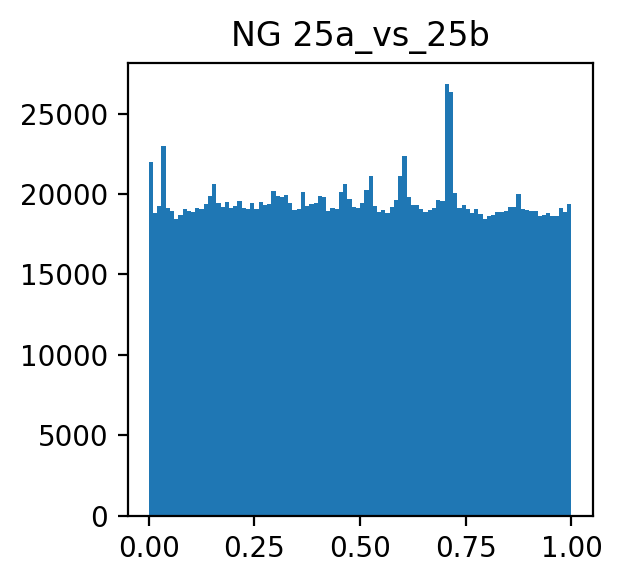

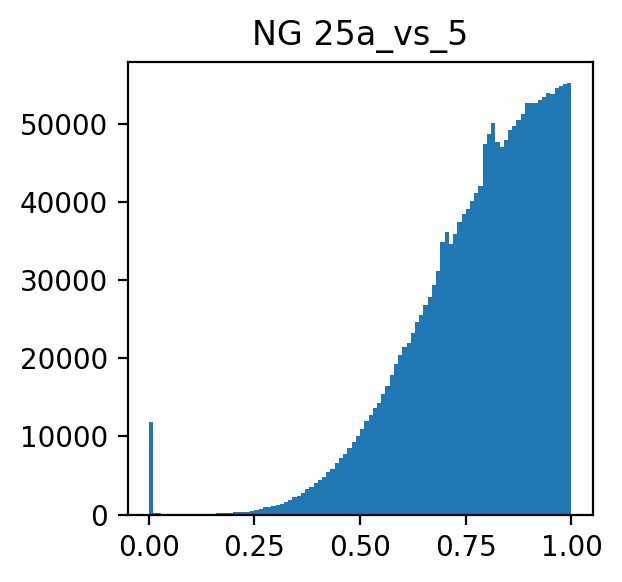

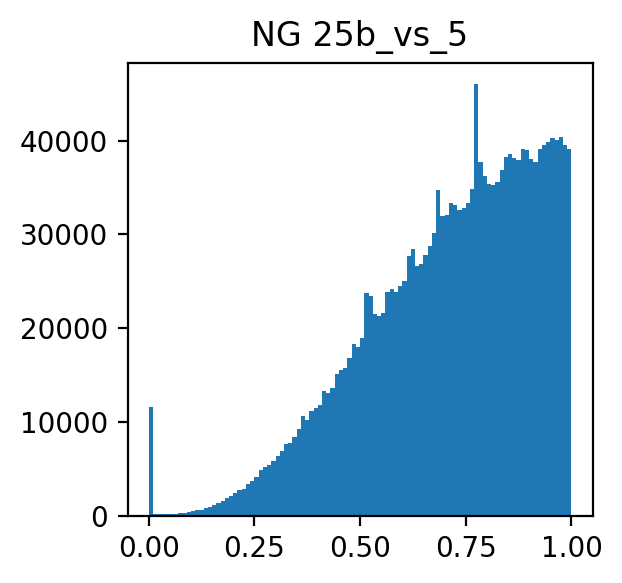

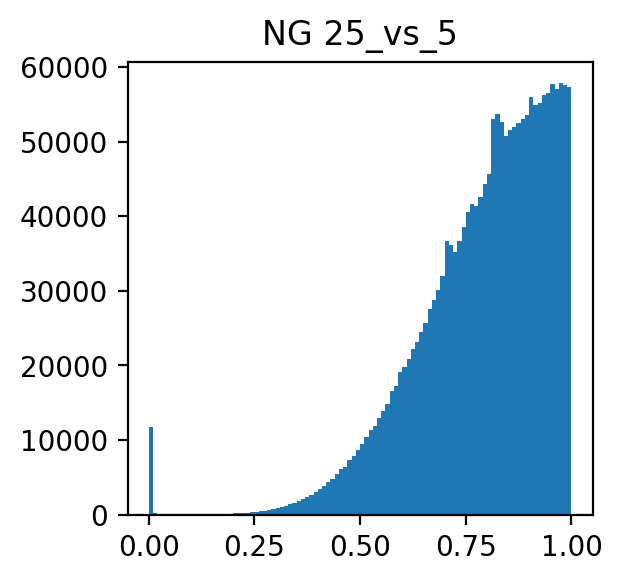

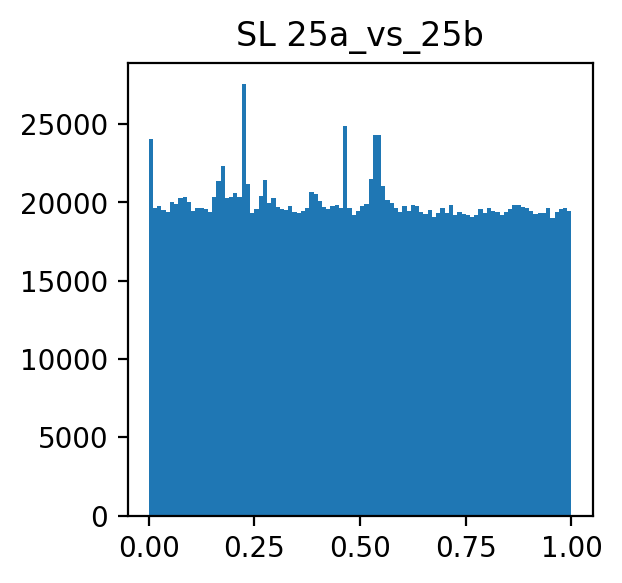

In [149]:
percountry_res = {}
for country in ['NG', 'SL']:
    percountry_res[country] = {}
    for c in comparison_strs:
        if (country == 'SL') and (c != '25a_vs_25b'):
            continue
        fn = '../../data/tmp/plink/merged_pre2016/{comp}.{country}.NoDups.20210805.resultsCovCC.tsv'.format(comp=c, country=country)
        percountry_res[country][c] = pd.read_csv(fn, sep='\t')
        percountry_res[country][c]['logP'] = -1*percountry_res[country][c]['PVAL'].apply(np.log10)
        (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
        _ = ax.hist(percountry_res[country][c]['PVAL'], bins=100)
        ax.set_title(country + ' ' + c)

25a_vs_25b NG


PVAL,False,True
MLMA_P,,
False,1950413,38
True,1618,574


25a_vs_5 NG


PVAL,False,True
MLMA_P,,
False,1949996,442
True,0,9821


25b_vs_5 NG


PVAL,False,True
MLMA_P,,
False,1930536,0
True,387,9660


25_vs_5 NG


PVAL,False,True
MLMA_P,,
False,1954634,636
True,0,9561


25a_vs_25b SL


PVAL,False,True
MLMA_P,,
False,2001316,54
True,791,1555


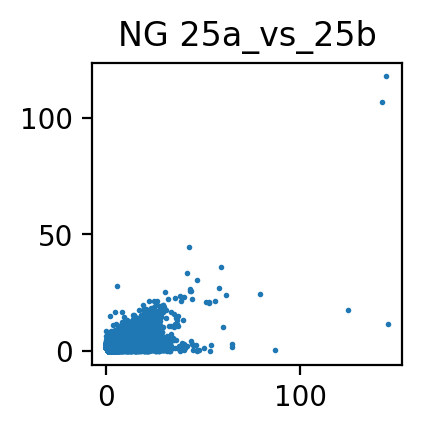

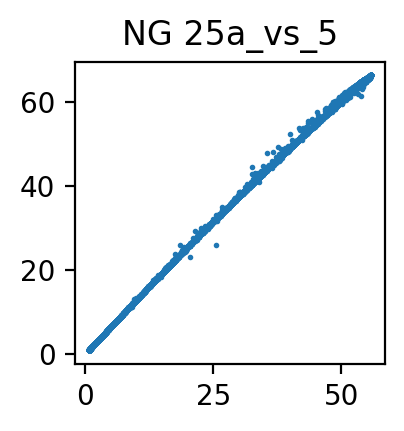

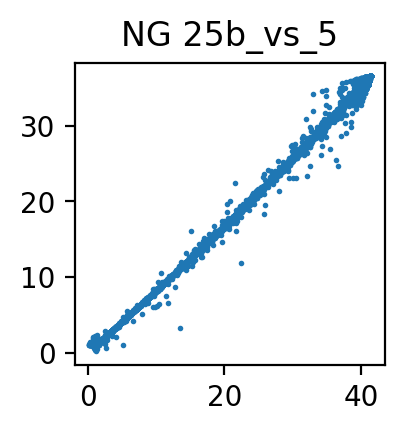

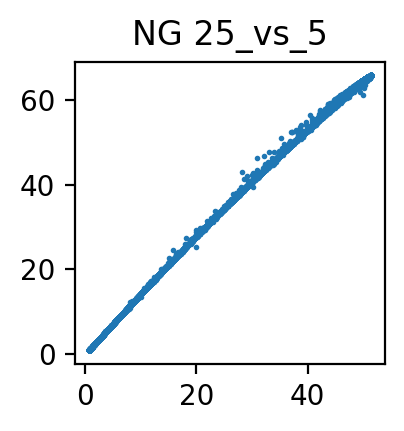

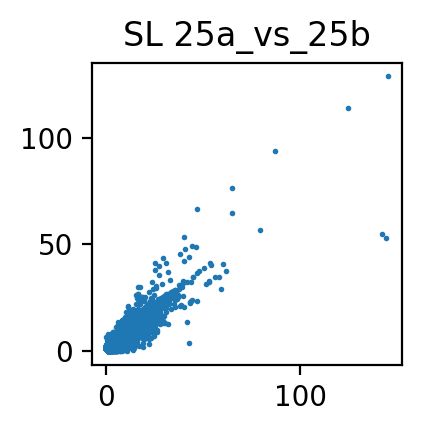

In [150]:
for country in ['NG', 'SL']:
    for (i,c) in enumerate(comparison_strs):
        if (country == 'SL') and (c != '25a_vs_25b'):
            continue
        (fig,axes) = plt.subplots(1,1, figsize=(2,2), dpi=200)
        percountry_res[country][c].index = percountry_res[country][c]['SNP']
        x = dupres[c][['MLMA_P', 'MLMA_logP']]
        y = percountry_res[country][c][['PVAL', 'logP']]
        m = pd.merge(left=x, right=y, left_index=True, right_index=True).dropna()
        print(c, country)
        display(pd.crosstab(m['MLMA_P']<5e-8, m['PVAL']<5e-8))
        ind = (m['MLMA_logP']>1) | (m['logP']>1)
        axes.scatter(m.loc[ind, 'MLMA_logP'], m.loc[ind, 'logP'], s=1)
        axes.set_title(country + ' ' +c)

In [151]:
for c in comparison_strs:
    for country in ['NG', 'SL']:
        
        if (country == 'SL') & (c != '25a_vs_25b'):
            continue        
            
        v = 'MLMA_%s_P' % country
        dupres[c][v] = np.nan
        ind = percountry_res[country][c].index
        dupres[c].loc[ind, v] = percountry_res[country][c].loc[ind, 'PVAL']
                
        ind = ~dupres[c][v].isnull()
        p = dupres[c].loc[ind, v].values
        (r,q) = fdrcorrection(p)  
        v2 = v.replace('_P', '_Q')
        dupres[c].loc[:,v2] = np.nan
        dupres[c].loc[ind,v2] = q
        

In [152]:
p_thresh = 1e-4
q_thresh = .5
for c in comparison_strs:
    x = dupres[c].shape[0]*p_thresh
    y = (dupres[c]['MLMA_P']< p_thresh).sum()
    z = (dupres[c]['MLMA_Q']< q_thresh).sum()
    w = (dupres[c]['MLMA_NG_P']< p_thresh).sum()
    t =  (dupres[c]['MLMA_NG_Q']< q_thresh).sum()
    if (c == '25a_vs_25b'):
        a = (dupres[c]['MLMA_SL_P']< p_thresh).sum()
        b =  (dupres[c]['MLMA_SL_Q']< q_thresh).sum()
        print(c, x, y, z, w, t, a, b)
    else:
        print(c, x, y, z, w, t)    


25a_vs_25b 230.8998 4278 11270 1918 4876 3324 8275
25a_vs_5 230.8998 10779 11346 11098 11591
25b_vs_5 230.8998 11023 11654 10694 11303
25_vs_5 230.8998 10577 11175 11031 11544


Text(0.5, 0, 'q-value threshold')

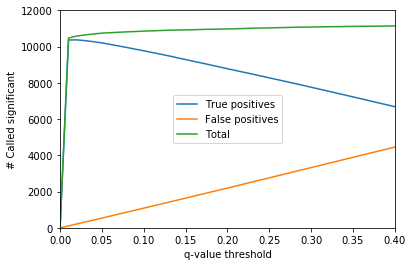

In [153]:
c = '25_vs_5'
resx = []
for t in np.linspace(0, 1, 100):
    n = (dupres[c]['MLMA_Q']<t).sum()
    fp = n*t
    tp = n - fp
    resx.append([t, n,fp, tp])
    
resx = pd.DataFrame(resx)

plt.plot(resx[0], resx[3], label='True positives')
plt.plot(resx[0], resx[2], label='False positives')
plt.plot(resx[0], resx[1], label='Total')

plt.xlim([0,.4])
plt.ylim([0,12000])
plt.legend()
plt.ylabel('# Called significant')
plt.xlabel('q-value threshold')

Text(0.5, 0, 'q-value threshold')

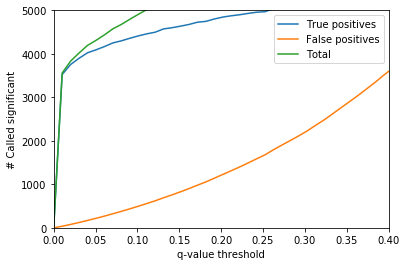

In [154]:
c = '25a_vs_25b'
resx = []
for t in np.linspace(0, 1, 100):
    n = (dupres[c]['MLMA_Q']<t).sum()
    fp = n*t
    tp = n - fp
    resx.append([t, n,fp, tp])
    
resx = pd.DataFrame(resx)

plt.plot(resx[0], resx[3], label='True positives')
plt.plot(resx[0], resx[2], label='False positives')
plt.plot(resx[0], resx[1], label='Total')

plt.xlim([0,.4])
plt.ylim([0,5000])
plt.legend()
plt.ylabel('# Called significant')
plt.xlabel('q-value threshold')

## Output batch-effected variants to filter and filter

In [155]:
q_thresh = .25
discthresh = .1
allfilterlist = set()

for c in comparison_strs:
    tofilterlist = set()
    tofilterlist = tofilterlist.union(set(dupres[c].index[dupres[c]['Between_AllRep_FracConcordant']>discthresh]))
    tofilterlist = tofilterlist.union(set(dupres[c].index[dupres[c]['MLMA_Q']<q_thresh]))
    tofilterlist = tofilterlist.union(set(dupres[c].index[dupres[c]['MLMA_NG_Q']<q_thresh]))

    
    print(c, 'replicates', len(dupres[c].index[dupres[c]['Between_AllRep_FracConcordant']>discthresh]))
    print(c, 'combined AF', len(dupres[c].index[dupres[c]['MLMA_Q']<q_thresh]))
    print(c, 'NG AF', len(dupres[c].index[dupres[c]['MLMA_NG_Q']<q_thresh]))
    if c == '25a_vs_25b':
        print(c, 'SL AF', len(dupres[c].index[dupres[c]['MLMA_SL_Q']<q_thresh]))
        tofilterlist = tofilterlist.union(set(dupres[c].index[dupres[c]['MLMA_SL_Q']<q_thresh]))
        
    print(c, len(tofilterlist))
    allfilterlist = allfilterlist.union(tofilterlist)
    dupres[c]['Filtered'] = dupres[c].index.isin(tofilterlist)
    print(len(allfilterlist))
    print('\n\n')

25a_vs_25b replicates 826
25a_vs_25b combined AF 6636
25a_vs_25b NG AF 2884
25a_vs_25b SL AF 4972
25a_vs_25b 8814
8814



25a_vs_5 replicates 13240
25a_vs_5 combined AF 11208
25a_vs_5 NG AF 11492
25a_vs_5 13250
22019



25b_vs_5 replicates 0
25b_vs_5 combined AF 11491
25b_vs_5 NG AF 11153
25b_vs_5 11492
22099



25_vs_5 replicates 13240
25_vs_5 combined AF 11033
25_vs_5 NG AF 11442
25_vs_5 13246
22101





In [156]:
print(comparison_strs)
for v in comparison_strs:
    local = '../../data/tmp/plink/merged_pre2016/BroadPre2016.%s.DuplicateDiscrepancyCounts.WithMLMA.WithPerCountry.20210805.CovCC.minfilt.tsv' % v
    dupres[v].to_csv(local, sep='\t')
    remote = 'gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/'
    cmd = 'gsutil -m cp {local} {remote}'.format(local=local, remote=remote)
    print(cmd)
    !{cmd}

['25a_vs_25b', '25a_vs_5', '25b_vs_5', '25_vs_5']
gsutil -m cp ../../data/tmp/plink/merged_pre2016/BroadPre2016.25a_vs_25b.DuplicateDiscrepancyCounts.WithMLMA.WithPerCountry.20210805.CovCC.minfilt.tsv gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/
Copying file://../../data/tmp/plink/merged_pre2016/BroadPre2016.25a_vs_25b.DuplicateDiscrepancyCounts.WithMLMA.WithPerCountry.20210805.CovCC.minfilt.tsv [Content-Type=text/tab-separated-values]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
